# F1 Racing Simulator

Simulating F1 racing with various control variables such as budgets, drivers and weather.

Weather will increase the randomness of driver failing to finish the race because they crashed.

In [1]:
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from teams import Team

### Step 1: play with the values
Play with the team budget or the possiblity of crashing or the point scale.
Everything down below is for you to control and experiment.

In [2]:
# Each team has certain amount of budget that they can use to research and produce faster cars.
# Team("Team name", budget(int) in millions)

# The values below are from the website below
# Team budget: https://beyondtheflag.com/2019/11/06/formula-1-current-team-budgets-175m-cap-impending/
F1_teams = {
    'mercedes': Team("Mercedes", 484),
    'redbull': Team("Red Bull", 445),
    'ferrari': Team("Ferrari", 463),
    'mclaren': Team("McLaren", 269),
    'renault': Team("Renault", 272),
    'racingpoint': Team("Racing Point", 188),
    'haas': Team("Haas", 173),
    'alfaromeo': Team("Alfa Romeo Racing", 141),
    'tororosso': Team("Toro Rosso", 138),
    'williams': Team("Williams", 132)
}

# Possibility for a driver to not finish a race (value  x 10%)
# e.g. if the road is soaked with water due to raining, the percentage of a driver
#      crashing their cars and not finish the race is 40%
posibility={'normal': 1, 'poor': 3, 'raining': 4}

# How much driver earns per race starting from 1st to 10th.
point_scale = [25, 18, 15, 12, 10, 8, 6, 4, 2, 1]  


sim_params = config_sim({
    'N': 1, # Number of seasons to run.
    'T': range(5), # Number of races per season.
    'M': {
        # Road condition for current season.
        # Options: 'normal' 'poor' 'raining'
        "road_condition": ['raining']
    }
})

genesis_states = {'Race_teams': F1_teams}

### Step 2: generate policy functions.
Policy function will determine how many points each team earns.\
For now, the fastest car will always win the race.

In [3]:
import random
random.seed()

# Policy functions
def p_update_rank(_params, substep, sH, s, **kwargs):
    
    road_condition = _params["road_condition"]

    prev_state = s['Race_teams']
    
    # For now, the team with a fastest car will win
    sorted_state = sorted(F1_teams.items(), key=lambda team:team[1].car_speed(), reverse=True)
    
    # Generate points to add
    
    add_to_team: Dict[str, int] = {}
        
    # There are 2 drivers per team and they both drive in a race.
    # Which means each team has possibility to earn points twice.
        
    for i in range(0, 10):
        # Decide if driver will finish the race without crashing based on road condition
        driver1 = random.randrange(10)
        driver2 = random.randrange(10)
    
        if driver1 <= posibility[road_condition]:
            add_to_team.update({sorted_state[i][0]: 0})
        else:
            add_to_team.update({sorted_state[i][0]: point_scale[i]})
            
        if driver2 <= posibility[road_condition]:
            add_to_team.update({sorted_state[i][0]: 0})
        else:
            add_to_team.update({sorted_state[i][0]: point_scale[i]})
        
    return add_to_team

### Step 3: generate state update function.
This function will update the values according to the policy function input.

In [4]:
# State update function
def s_team(_params, substep, sH, s, _input, **kwargs):
    
    prev_state = s['Race_teams']
    
    new_state = {}
    
    for key, value in prev_state.items():
        points = value.get_points()
        
        total = points + _input[key]
        
        new_state[key] = Team(value.get_name(), value.get_budget())
        
        new_state[key].add_points(total)
        
    return ('Race_teams', new_state)
    

In [5]:
# Partial update blocks
PUB = [{
    "policies":
    {
        "action": p_update_rank
    },
    "variables":
    {
        'Race_teams': s_team
    }
}]

### Step 4: setup the simulation.

In [6]:
exp = Experiment()
exp.append_model(
    initial_state = genesis_states, 
    partial_state_update_blocks = PUB, 
    sim_configs=sim_params)

config = exp.configs

### Step 5: run the simulation.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

exec_mode = ExecutionMode()
local_proc_ctx = ExecutionContext(context=exec_mode.local_mode)

run = Executor(exec_context=local_proc_ctx, configs=config)

raw_result, tensor_fields, _ = run.execute()
result = pd.DataFrame(raw_result)

# Uncomment the line below if you want to see the full raw result
# print(tabulate(result, headers='keys', tablefmt='psql'))


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 5, 1, 1, 1)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (5, 1, 1, 1)
Execution Method: local_simulations
Execution Mode: single_threaded
Total execution time: 0.00s


### Finally, see the result.

Text(0, 0.5, 'Points')

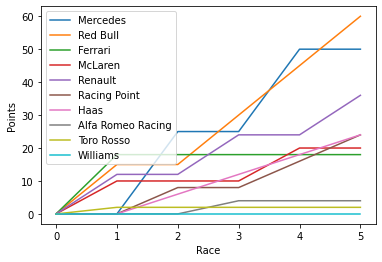

In [8]:
new_result = []
for i in raw_result:
    row = {}
    for key, value in i.items():
        if key == 'Race_teams':
            for key, value in value.items():
                row.update({value.get_name(): value.get_points()})
        elif key == 'timestep':
            row.update({key: value})
    new_result.append(row)

graph = pd.DataFrame(new_result).plot('timestep')
graph.set_xlabel("Race")
graph.set_ylabel("Points")